In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = [224, 224]

In [4]:
train_directory='../Dataset/train'
test_directory='../Dataset/test'
val_directory='../Dataset/valid'

In [5]:
# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

2022-04-06 20:52:38.763056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-06 20:52:38.763416: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [6]:
  # useful for getting number of classes
folders = glob('../Dataset/train/*')
len(folders)

400

In [7]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [8]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./113, shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory(train_directory,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_directory,
                                            target_size = (112, 112),
                                            batch_size = 32,
                                            class_mode = 'categorical')

val_set = val_datagen.flow_from_directory(val_directory,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')
print(train_datagen)

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


In [30]:
print(len(training_set))
print(len(test_set))

1825
63


In [14]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/var/folders/08/pl_vxn2x4r31x240qkqfhjdm0000gn/T/ipykernel_74297/45505765.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/15


2022-04-02 08:25:28.199943: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-02 08:25:28.432593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

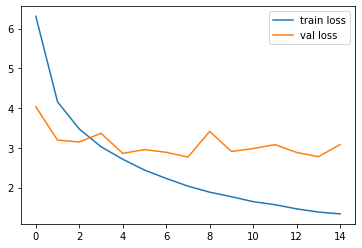

In [14]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

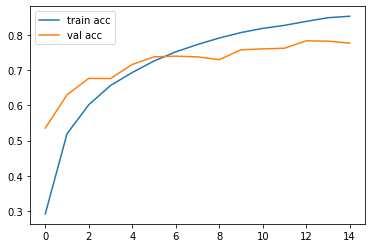

In [15]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [16]:
model.save('Abhi_preditionmodel19.h5')

In [17]:
from keras.models import load_model
from keras.preprocessing.image import load_img,img_to_array

model1 = load_model('Abhi_preditionmodel19.h5',compile=False)  

In [18]:
lab = training_set.class_indices
lab={k:v for v,k in lab.items()}

In [19]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model1.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = lab[y]
    return res

'CROW'

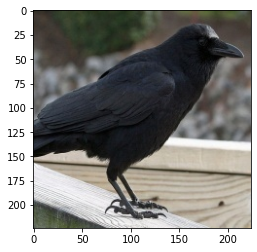

In [21]:
img='../Dataset/valid/CROW/4.jpg'
pic=load_img('../Dataset/valid/CROW/4.jpg',target_size=(224,224,3))
plt.imshow(pic)
output(img)

In [22]:
import tensorflow as tf
import keras as k
print(tf.__version__)
print(k.__version__)

2.8.0
2.8.0


In [35]:
from keras.models import load_model
from keras.preprocessing.image import load_img,img_to_array

model1 = load_model('/Users/abhinashsathi/Downloads/EfficientNetB4-BIRDS-0.99.h5',compile=True)  
#model1 = load_model('/Users/abhinashsathi/Downloads/Team - 1/Model code files/model.h5',compile=True)  

In [39]:
#x_test = test_datagen.flow_from_directory(test_set,target_size=(64,64),batch_size=32,class_mode='categorical')

pred=model1.evaluate(test_set)
#print(pred)

63/63 [==============================] - 14s 202ms/step - loss: 9.4872 - accuracy: 0.0025


In [36]:
labels= test_set.labels
errors=0
for i, p in enumerate(pred):
    pred_index=np.argmax(p)         
    true_index=labels[i]  
    if pred_index != true_index: 
         errors=errors + 1
print((1-errors/(len(pred))))

0.0024999999999999467
